### [MTA_Subway_Trains_Delayed__Beginning_2020_20241117.csv](https://data.ny.gov/Transportation/MTA-Subway-Trains-Delayed-Beginning-2020/wx2t-qtaz/about_data)
Columns: 
- __month__: The month in which subway trains delayed is being calculated (yyyy-mm-dd).
- __division__: The A Division (numbered subway lines), B Division (lettered subway lines) and systemwide.
- __line__: Each subway line (1, 2, 3, 4, 5, 6, 7, A, C, E, B, D, F, M, G, J, Z, L, N, Q, R, W, S 42nd, S Rock, S Fkln).
- __day_type__: Represents weekday as 1 and weekend as 2.
- __reporting_category__: The six categories that delays are reported under: Infrastructure & equipment, Crew availability, Police & medical, External Factors, Operating conditions, Planned ROW work. 
- __subcategory__: The sub-categories that fall under the definition of Delays: Braking; Door-Related; Fire, Smoke, Debris; Inclement Weather; Crew Availability; Insufficient Supplement Schedule; Propulsion; Public Conduct, Crime, Police Response; Rail and Roadbed; Persons on Roadbed; Service Delivery; Sick/Injured Customer; Train Brake Activation - Cause Unknown; Subways Maintenance; Work Equipment; Capital Work - Other Planned ROW; External Debris on Roadbed; External Agency or Utility; Capital Work - Other Planned ROW; Other – CE; Other – Sig; Other Infrastructure; Other Internal Disruptions.
- __delays__: The number of train delays per category and time period.

### [MTA Subway Customer Journey-Focused Metrics: Beginning 2020](https://data.ny.gov/Transportation/MTA-Subway-Customer-Journey-Focused-Metrics-Beginn/4apg-4kt9/about_data)
- __month__: The month in which the metrics are being calculated (yyyy-mm-dd).

- __division__: The A Division (numbered subway lines and S 42nd) and B Division (lettered subway lines).

- __line__: Each subway line (1, 2, 3, 4, 5, 6, 7, A, C, E, B, D, F, M, G, JZ, L, N, Q, R, W, S 42nd, S Rock, S Fkln). A systemwide row also exists for each month in the dataset.

- __period__: Represents both the peak and off-peak service periods.

- __num_passengers__: Total number of passengers reported each month and on each line.

- __additional platform time__: The average additional time in minutes (above scheduled time) customers wait for their train, reported each month and on each line.

- __additional train time__: The average additional time in minutes (above scheduled time) customers spend onboard a train, reported each month and on each line.

- __total_apt__: The total number of additional time in minutes (above scheduled time) customers wait for their train, reported each month and on each line.

- __total_att__: The total number of average additional time in minutes (above scheduled time) customers spend onboard a train, reported each month and on each line.

- __over_five_mins__: The estimated total number of customers whose journeys are not completed within 5 minutes of the scheduled time, reported each month and on each line

- __over_five_mins_perc__: The estimated percentage of customers whose journeys are not completed within 5 minutes of the scheduled time, reported each month and on each line.

- __customer journey time performance__: The estimated percentage of customers whose journeys are completed within 5 minutes of the scheduled time, reported each month and on each line.


# Data Cleaning

In [129]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt


# Load the dataset from the CSV file
file = 'MTA_Subway_Trains_Delayed__Beginning_2020_20241117.csv'
df = pd.read_csv(file)

# replace missing subcategories with reporting_category
df['subcategory'] = df['subcategory'].fillna(df['reporting_category'])

# replace "Other Operating Environment" with "Operating Conditions" to maintain parity
# a new "Service Management" subcategory was added in Aug 2024 which
# replaces the empty subcategory for "Operating Conditions"
df['subcategory'] = df['subcategory'].replace("Other Operating Environment", "Operating Conditions")

# drop the division and reporting_category columns, they are redundance info
df = df.drop(columns=['division', 'reporting_category'])

# remove S Rock, S Fkln, and GS (shuttles)
df = df[~df['line'].isin(['S Rock', 'S Fkln', 'GS'])]

df

,month,line,day_type,subcategory,delays
0,2024-10-01,1,1,Crew Availability,60
1,2024-10-01,1,1,External Debris on Roadbed,17
2,2024-10-01,1,1,Braking,20
3,2024-10-01,1,1,Door-Related,43
4,2024-10-01,1,1,"Fire, Smoke, Debris",30
...,...,...,...,...,...
39025,2020-01-01,R,2,Subways Maintenance,23
39026,2020-01-01,R,2,Work Equipment,3
39027,2020-01-01,R,2,Persons on Roadbed,4
39028,2020-01-01,R,2,"Public Conduct, Crime, Police Response",31


In [130]:
metrics_file = "MTA_Subway_Customer_Journey-Focused_Metrics__Beginning_2020_20241125.csv"
df_metrics = pd.read_csv(metrics_file)

# drop the division and 'customer journey time performance' columns, they are redundant info
df_metrics = df_metrics.drop(columns=['division', 'customer journey time performance'])


# remove S Rock, S Fkln, and S 42nd (shuttles)
df_metrics = df_metrics[~df_metrics['line'].isin(['S Rock', 'S Fkln', 'S 42nd'])]

# combine offpeak and peak metrics by multiplying each col by the number of passengers
# adding the 2 rows, then dividing by the total number of passengers for each col again
value_cols = [col for col in df_metrics.columns if col not in ["month", "division", "line", "period", "num_passengers"]]

for col in value_cols:
    df_metrics[col] *= df_metrics["num_passengers"]

# add rows with the same line and month
df_metrics = df_metrics.groupby(["month", "line"]).sum().reset_index()

# divide
for col in value_cols:
    df_metrics[col] /= df_metrics["num_passengers"]

# drop the period
df_metrics = df_metrics.drop(columns=['period'])

#sort by month 
df_metrics = df_metrics.sort_values(by=['month', 'line'])


# only keep the month, line, and a new col that sums total_att + total_apt
df_metrics = df_metrics[['month', 'line', 'total_apt', 'total_att']]
df_metrics['total_hrs_delayed'] = (df_metrics['total_apt'] + df_metrics['total_att']) / 60

# drop the total_apt and total_att cols
df_metrics = df_metrics.drop(columns=['total_apt', 'total_att'])

df_metrics

,month,line,total_hrs_delayed
0,2020-01-01,1,310840.456622
1,2020-01-01,2,164640.166864
2,2020-01-01,3,103155.722988
3,2020-01-01,4,125502.910150
4,2020-01-01,5,97664.484133
...,...,...,...
1208,2024-10-01,M,65180.914520
1209,2024-10-01,N,112223.010883
1210,2024-10-01,Q,133127.550623
1211,2024-10-01,R,113108.334194


# Data Reshaping

In [131]:
# pivot the delay subcategory rows into columns
df = df.pivot(index=['month', 'day_type', 'line'], columns='subcategory', values='delays').fillna(0)

# add rows with the same month but different day type
df = df.groupby(['month', 'line']).sum()

# merge with the metrics
df = pd.merge(df, df_metrics, how='inner', on=['month', 'line'])

# drop month
df = df.reset_index().drop(columns=['month'])

df


,index,line,Braking,Capital Work - Other Planned ROW,Crew Availability,Door-Related,External Agency or Utility,External Debris on Roadbed,"Fire, Smoke, Debris",Inclement Weather,...,"Public Conduct, Crime, Police Response",Rail and Roadbed,Service Delivery,Service Management,Sick/Injured Customer,Signal Modernization Capital Project,Subways Maintenance,Train Brake Activation - Cause Unknown,Work Equipment,total_hrs_delayed
0,0,1,2.0,1.0,27.0,85.0,306.0,8.0,27.0,0.0,...,231.0,105.0,68.0,0.0,120.0,0.0,118.0,3.0,10.0,310840.456622
1,1,2,6.0,6.0,19.0,28.0,234.0,16.0,7.0,20.0,...,256.0,54.0,26.0,0.0,109.0,0.0,274.0,16.0,31.0,164640.166864
2,2,3,2.0,2.0,9.0,15.0,212.0,16.0,4.0,1.0,...,144.0,60.0,8.0,0.0,68.0,0.0,145.0,9.0,19.0,103155.722988
3,3,4,0.0,37.0,21.0,37.0,61.0,32.0,4.0,22.0,...,312.0,86.0,69.0,0.0,195.0,0.0,274.0,14.0,23.0,125502.910150
4,4,5,4.0,0.0,9.0,41.0,106.0,18.0,16.0,19.0,...,227.0,59.0,45.0,0.0,156.0,0.0,71.0,22.0,4.0,97664.484133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152,1152,L,19.0,20.0,110.0,2.0,0.0,4.0,1.0,0.0,...,127.0,28.0,45.0,0.0,73.0,11.0,218.0,3.0,0.0,62944.808469
1153,1153,M,14.0,57.0,160.0,4.0,4.0,35.0,0.0,0.0,...,128.0,91.0,27.0,0.0,23.0,37.0,195.0,28.0,32.0,65180.914520
1154,1154,N,8.0,41.0,270.0,123.0,1.0,3.0,46.0,0.0,...,483.0,203.0,50.0,0.0,44.0,3.0,836.0,13.0,151.0,112223.010883
1155,1155,Q,7.0,3.0,162.0,37.0,6.0,15.0,24.0,0.0,...,415.0,139.0,64.0,0.0,63.0,7.0,461.0,28.0,58.0,133127.550623


# Split training and testing data

In [132]:
line_groups = [
    ["N", "A", "F", "6", "2", "E"],
    ["Q", "D", "4", "1"],
    ["R", "7", "C", "5", "3"],
    ["L", "B", "JZ", "G", "M"]
]
group_to_use = line_groups[0]

line_to_test = random.choice(group_to_use)

#filter the data to only include the group
df = df[df['line'].isin(group_to_use)]

# temporarily split the data to test and train and then append the training data at the end
df_train = df[df['line'] != line_to_test]
df_test = df[df['line'] == line_to_test]
df = pd.concat([df_train, df_test])

train_size = len(df) - len(df_test)

# drop line
df = df.drop(columns=['line'])

#get the features and target
features = np.array(df.drop(columns=['total_hrs_delayed']))
target = np.array(df['total_hrs_delayed']).reshape(-1, 1)


# LSTM Model

In [133]:
# normalize the data
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target)

In [134]:
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(target[i + time_steps])

    return np.array(X), np.array(y)

X, y = create_sequences(scaled_features, scaled_target, 6)

# reshape to (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

X, y

(array([[[0.        , 0.03658537, 0.01134216, ..., 0.21447485,
          0.17021277, 0.18562874],
         [0.00346921, 0.07317073, 0.06049149, ..., 0.13503972,
          0.25531915, 0.23952096],
         [0.00520382, 0.0304878 , 0.1436673 , ..., 0.43865843,
          0.15957447, 0.07185629],
         [0.00867303, 0.05487805, 0.11909263, ..., 0.22241836,
          0.31914894, 0.02994012],
         [0.00954033, 0.12804878, 0.48771267, ..., 0.66107679,
          0.67021277, 0.17964072],
         [0.01734605, 0.04878049, 0.00189036, ..., 0.24801412,
          0.5106383 , 0.24550898]],
 
        [[0.00346921, 0.07317073, 0.06049149, ..., 0.13503972,
          0.25531915, 0.23952096],
         [0.00520382, 0.0304878 , 0.1436673 , ..., 0.43865843,
          0.15957447, 0.07185629],
         [0.00867303, 0.05487805, 0.11909263, ..., 0.22241836,
          0.31914894, 0.02994012],
         [0.00954033, 0.12804878, 0.48771267, ..., 0.66107679,
          0.67021277, 0.17964072],
         [0.01734

In [135]:
# split the data into training and testing sets
X_train = X[:train_size]
X_test = X[train_size:]

y_train = y[:train_size]
y_test = y[train_size:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((290, 6, 27), (52, 6, 27), (290, 1), (52, 1))

In [136]:
# build the LSTM model
model = Sequential()

model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
train_loss = model.evaluate(X_train, y_train)
print(f"Train Loss: {train_loss}")

test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# predict the delays for the line left for testing
y_pred = model.predict(X_test)

y_pred_scaled = scaler.inverse_transform(y_pred)
y_test_scaled = scaler.inverse_transform(y_test)

print(y_pred.reshape(-1))
print(y_test.reshape(-1))

Epoch 1/100


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0734 - val_loss: 0.0996
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0279 - val_loss: 0.0102
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0227 - val_loss: 0.0144
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0184 - val_loss: 0.0271
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0160 - val_loss: 0.0121
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0161 - val_loss: 0.0258
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0174 - val_loss: 0.0159
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0154 - val_loss: 0.0098
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0130 - val_loss: 0.0237
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0161 - val_loss: 0.0132
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0126 - val_loss: 0.0146
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0127 - val_l

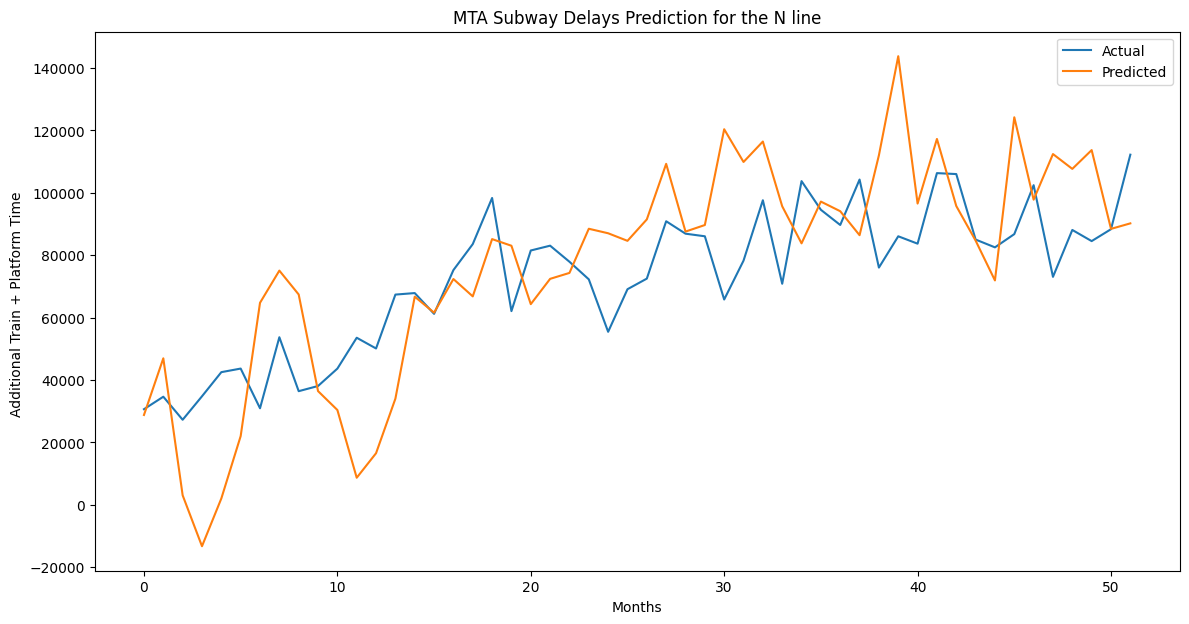

In [137]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_scaled, label='Actual')
plt.plot(y_pred_scaled, label='Predicted')

plt.title(f'MTA Subway Delays Prediction for the {line_to_test} line')
plt.ylabel("Additional Train + Platform Time ")
plt.xlabel("Months")
plt.legend()
plt.show()